In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib nbagg
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from pathlib import Path

import haiku as hk
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'
import jax
from jax.experimental import optix
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from nsec.normalization import SNParamsTree as CustomSNParamsTree
import pickle
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except IndexError:
    pass
from tqdm.notebook import tqdm

from nsec.datasets.fastmri import mri_noisy_generator
from nsec.mri.model import get_model

In [2]:
plt.rcParams['image.cmap'] = 'gray'

In [3]:
batch_size = 32
contrast = 'CORPD_FBK'
magnitude_images = True
noise_power_spec = 3*1e1
val_mri_gen = mri_noisy_generator(
    split='val',
    scale_factor=1e6,
    noise_power_spec=noise_power_spec,
    batch_size=batch_size,
    contrast=contrast,
    magnitude=magnitude_images,
    image_size=320,
)
##### BATCH DEFINITION
# (image_noisy, noise_power), noise_realisation
# here the noise_realisation is the full one, not the epsilon from the standard normal law

In [4]:
model, loss_fn, _, _, _, _, _, rng_seq = get_model(opt=False, magnitude_images=True, pad_crop=False, stride=False)

/volatile/home/Zaccharie/workspace/score-estimation-comparison/venv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
# Importing saved model
with open('../conv-dae-L2-mri-30.0_mag_no_stride_backup.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [6]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [7]:
(x, s), su = next(val_mri_gen)
s = s[..., None, None, None]
res, state = score(x, s, is_training=False)

<IPython.core.display.Javascript object>


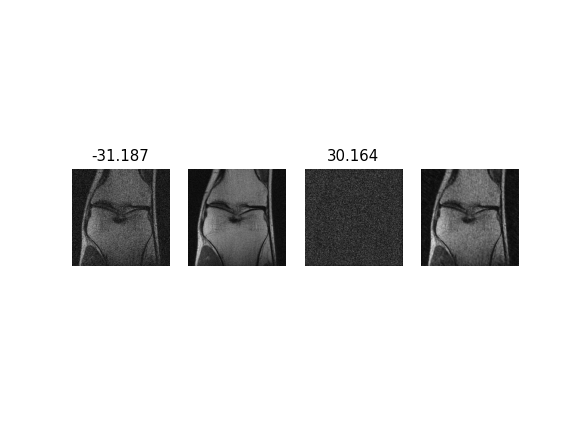

<IPython.core.display.Javascript object>


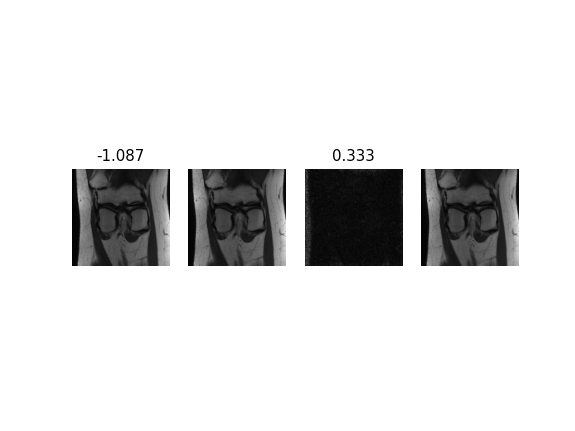

<IPython.core.display.Javascript object>


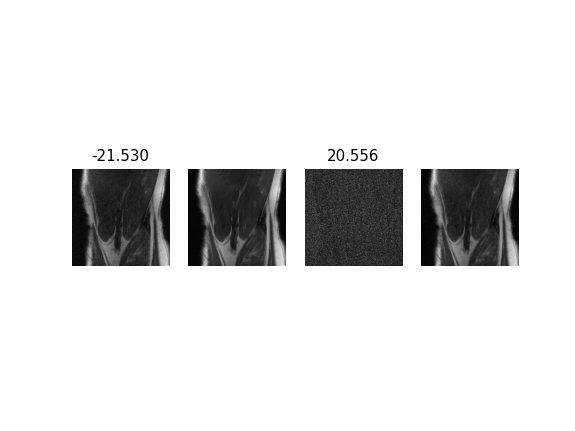

<IPython.core.display.Javascript object>


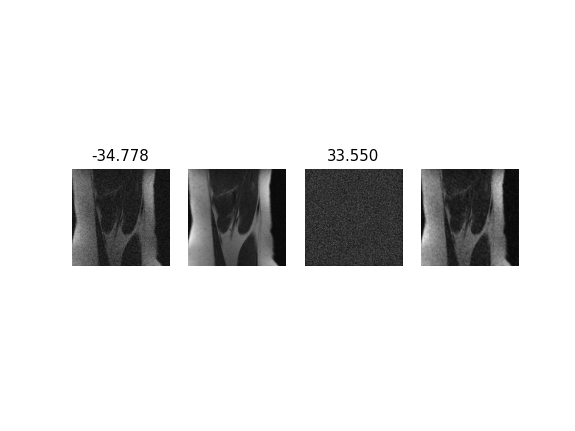

<IPython.core.display.Javascript object>


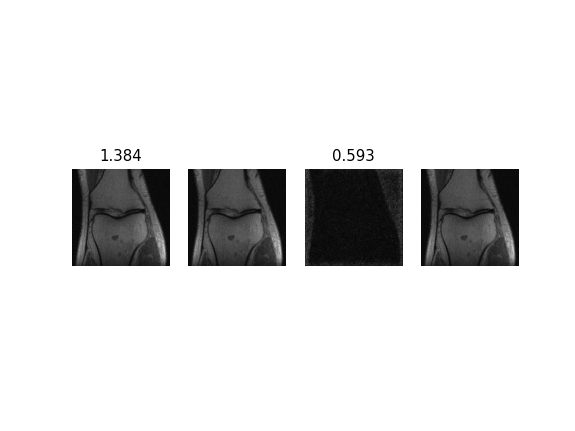

<IPython.core.display.Javascript object>


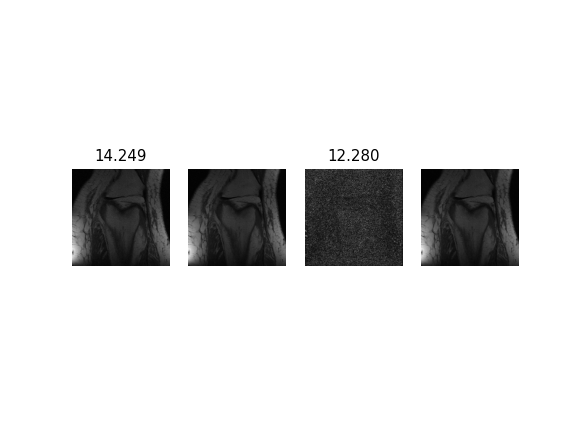

<IPython.core.display.Javascript object>


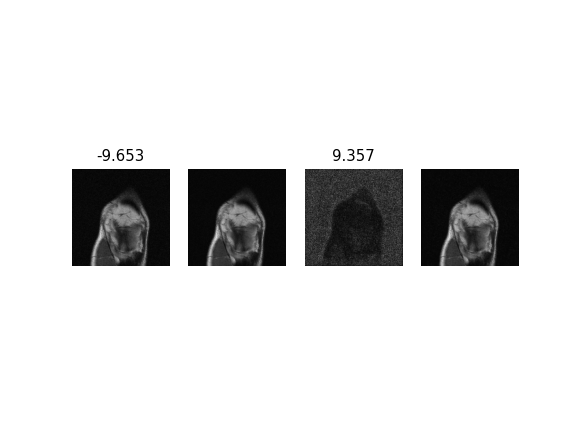

<IPython.core.display.Javascript object>


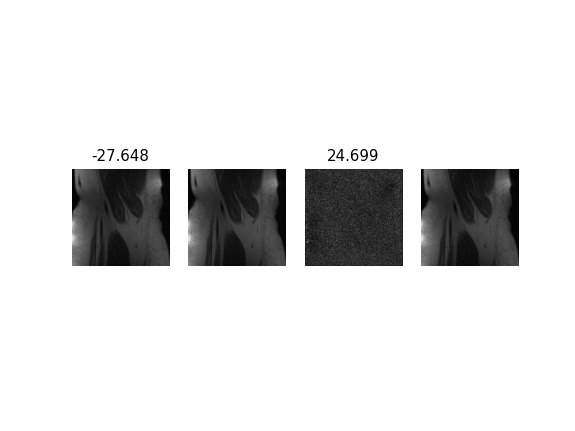

<IPython.core.display.Javascript object>


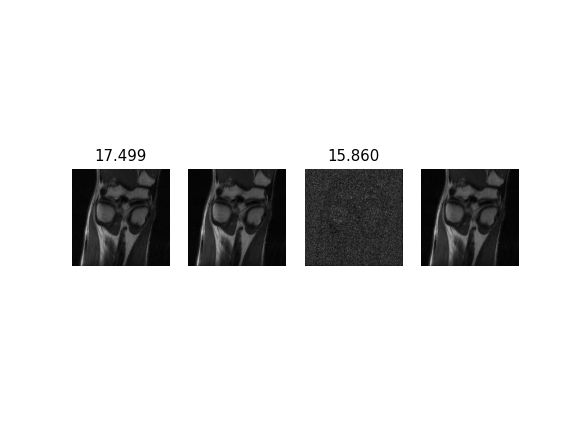

<IPython.core.display.Javascript object>


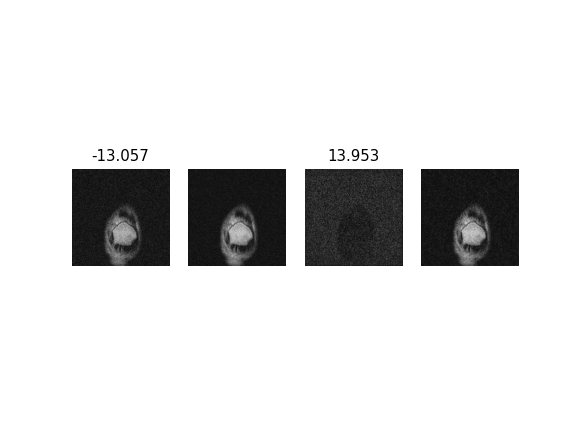

In [8]:
for i in range(10):
    ind = i
    fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
    axs[0].set_title("%0.3f"%s[ind,0,0,0])
    axs[0].imshow(jnp.abs(x)[ind,...,0],cmap='gray')
    axs[0].axis('off')
    axs[1].imshow(jnp.abs(x - su)[ind,...,0],cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(jnp.abs(res)[ind,...,0],cmap='gray')
    axs[2].axis('off')
    axs[2].set_title("%0.3f"%jnp.std(s[ind,:,:,0]**2 *res[ind,...,0]))
    axs[3].imshow(jnp.abs(x[ind,...,0] + s[ind,:,:,0]**2 * res[ind,...,0]),cmap='gray')
    axs[3].axis('off')

In [9]:
# Trying to sample from the model

<IPython.core.display.Javascript object>


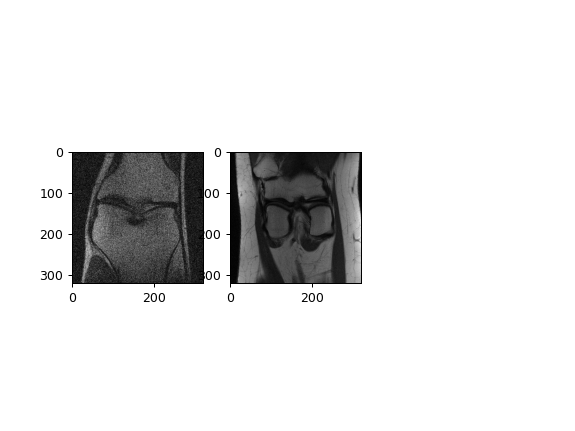

In [10]:
plt.figure()
plt.subplot(131)
plt.imshow(jnp.abs(x)[0,...,0].reshape((320,320,)))
plt.subplot(132)
plt.imshow(jnp.abs(x)[1,...,0].reshape((320,320,)))
# subplot(133)
# imshow(x[2,...,0].reshape((320,320,)))

In [11]:
x.shape

(32, 320, 320, 1)

In [12]:
mask = np.ones_like(x[0:1])
mask[:, 130:170, 170:200] = 0

In [13]:
x_black = np.copy(x[0:1])
x_black = x_black * mask

<IPython.core.display.Javascript object>


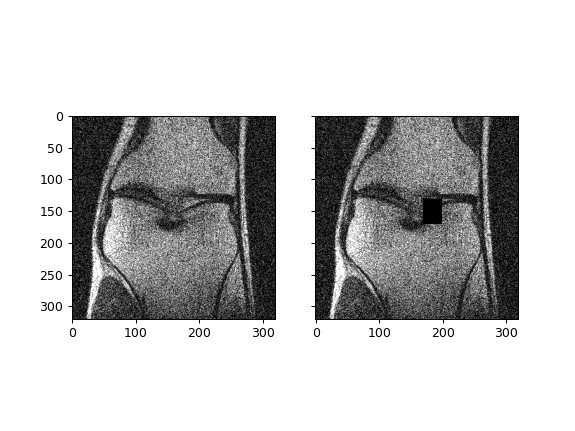

In [14]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(jnp.squeeze(jnp.abs(x[0])), vmin=10, vmax=150)
axs[1].imshow(jnp.squeeze(jnp.abs(x_black[0])), vmin=10, vmax=150)

In [ ]:
# gradient descent for MAP, with step size eps
eps = 1*1e-5
n_max = int(1*1e4)
intermediate_images = []
im_save_freq = int(1*1e3)
temp = 1e-4

@jax.jit
def update(x_old):
    x_new = x_old + eps * score(x_old, jnp.zeros((1,1,1,1))+temp, is_training=False)[0]
    x_new = x_new * (1-mask) + mask * x_black
    return x_new

x_old = np.copy(x_black)
for i_step in tqdm(range(n_max)):
    x_new = update(x_old)
    if (i_step + 1) % im_save_freq == 0:
        intermediate_images.append(x_new.block_until_ready())
    x_old = x_new

In [ ]:
fig, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(9, 5))
axs[0, 0].imshow(jnp.squeeze(jnp.abs(x[0])), vmin=0, vmax=150)
axs[0, 1].imshow(jnp.squeeze(jnp.abs(x_black[0])), vmin=0, vmax=150)
for i in range(len(intermediate_images)):
    if i < 4:
        ax = axs[0, i+2]
    else:
        ax = axs[1, i - 4]
    ax.imshow(jnp.squeeze(jnp.abs(intermediate_images[i])), vmin=0, vmax=150)